Experiment with different discounting methods estimating the frequency of words in English. 
In particular, evaluate the degree to which frequencies on short text files (1000 words, 10,000 words, 100,000 words, and 1,000,000 words)reflect the frequencies over some large text corpora, say, 10,000,000 words.
Mount google drive
File used 


In [115]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
for dirname, _, filenames in os.walk('drive/My Drive/bbc-project/task2data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Mounted at /content/drive
drive/My Drive/bbc-project/task2data/1000wordfile.txt
drive/My Drive/bbc-project/task2data/10000wordfile.txt
drive/My Drive/bbc-project/task2data/100000wordfile.txt
drive/My Drive/bbc-project/task2data/1000000wordfile.txt


1. Tokenization - Convert large text file into words
1. Cleansing - Reamove puncuation and tags
1. Stemming  - remove suffix, prefix and unncessary chars
1. Lemmatization  - Remove inflection by determining the part of speech and utilizing detailed database of the language.
#### Ref https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958

In [116]:
# Install spark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
from pyspark.sql.types import StructType,StructField,DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [118]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark



In [119]:
data = spark.read.option("wholetext",True).text('drive/My Drive/bbc-project/task2data/100000wordfile.txt')

+--------------------+
|               value|
+--------------------+
|Recap: What did J...|
|We'll be bringing...|
|In his written su...|
|However, he argue...|
|Johnson also clai...|
|He argues it was ...|
|He rejects the co...|
|If this was the c...|
|He also attempts ...|
|The committee say...|
|Earlier, Prime Mi...|
|And here is our w...|
|The Covid-19 Bere...|
|                    |
|Writing on Twitte...|
|                    |
|It adds: "Far wor...|
|                    |
|Meanwhile, a woma...|
|                    |
+--------------------+
only showing top 20 rows



In [120]:
data.printSchema()

root
 |-- value: string (nullable = true)



In [121]:
from pyspark.sql.types import StringType
data = data.withColumn('value', data['value'].cast(StringType()))

In [122]:
col_list = ['value']
data = data.select([column for column in data.columns if column in col_list])

In [123]:
data.show(1)

+--------------------+
|               value|
+--------------------+
|Recap: What did J...|
+--------------------+
only showing top 1 row



In [124]:
import gensim.parsing.preprocessing as gsp
from pyspark.sql.types import StringType
from gensim import utils


filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(x):
    s = x[0]
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return (s)

In [125]:
input_rdd = data.rdd.map(lambda x : (clean_text(x),))

input_df  = input_rdd.toDF()

In [126]:
input_df.show(1)

+------------------+
|                _1|
+------------------+
|recap johnson evid|
+------------------+
only showing top 1 row



In [127]:
df_bbc = input_df.toPandas()


In [128]:
df_bbc.rename(columns={"_1": "text"}, inplace=True)

**Remove Empty Lines**

In [129]:
import numpy as np
df_bbc.replace('', np.nan, inplace=True)
df_bbc.dropna(subset=['text'], inplace=True)

In [130]:
df_bbc.head()

,text
0,recap johnson evid
1,bring live coverag close shortli summari kei p...
2,written submiss johnson accept misl mp stateme...
3,argu intention recklessli mislead common state...
4,johnson claim correct record earliest opportun...


In [131]:
uniqe_rows = df_bbc['text'].value_counts()
#textmessage = category_counts.index
#print(textmessage)

In [132]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
# Stemming Libraries
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
from nltk.stem.porter import PorterStemmer
pm = PorterStemmer()
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text Preprocessing

In [133]:
data = np.asarray(df_bbc)
#no_cluster = len(df_bbc)
no_cluster = 1

temp_text = []
temp_text_lemma = []
temp_text_stem = []

cleaned_texts = []
cleaned_texts_lemma = []
cleaned_texts_stem = []

In [134]:
for i in range(len(data)):
    temp_text.append([])
    temp_text_lemma.append([])
    temp_text_stem.append([])
    temp_text[i] = re.sub('[^a-zA-Z]', ' ', data[i][0] )                                                                      # Remove all punctuations
    temp_text[i] = temp_text[i].lower()
    temp_text[i] = temp_text[i].split()
    temp_text_lemma[i] = [lm.lemmatize(word) for word in temp_text[i] if not word in set(stopwords.words('english')) ]           # First stemming method 
    temp_text_stem[i] = [pm.stem(word) for word in temp_text[i] if not word in set(stopwords.words('english'))]                  # Second stemming method
    temp_text[i] = [word for word in temp_text[i] if not word in set(stopwords.words('english')) ]                         # we didn't use stemming method, just get rid of stopwords
    cleaned_texts.append(temp_text[i])
    cleaned_texts_lemma.append(temp_text_lemma[i])
    cleaned_texts_stem.append(temp_text_stem[i])

In [135]:
# Vectorize all words

from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer

def word_sentinizer(txt, model):
    text_vect = []
    no_words = 0
    for word in txt:
        if no_words ==  0:
            text_vect = model[word]
        else:
            text_vect = np.add(text_vect, model[word])
        no_words += 1
    return np.asarray(text_vect) / no_words

# Vectorizing withot cleaning
X = []
model = Word2Vec(cleaned_texts, min_count = 1)
for text in cleaned_texts:
    X.append(word_sentinizer(text, model))
    
# Vectorizing with WordNetLemmatizer 
X_lemma = []
model_lemma = Word2Vec(cleaned_texts_lemma, min_count = 1)
for text in cleaned_texts_lemma:
    X_lemma.append(word_sentinizer(text, model_lemma))
    

# Vectorizing with PorterStemmer      
X_stem = []
model_stem = Word2Vec(cleaned_texts_stem, min_count = 1)
for text in cleaned_texts_stem:
    X_stem.append(word_sentinizer(text, model_stem))


<ipython-input-135-8fd7acb3d839>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  text_vect = model[word]
<ipython-input-135-8fd7acb3d839>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  text_vect = np.add(text_vect, model[word])


In [136]:
# Clustering vectorized words
kclusterer = KMeansClusterer(no_cluster, distance= nltk.cluster.util.cosine_distance, repeats = 100)

assigned_clusterers = kclusterer.cluster(X, assign_clusters = True)
assigned_clusterers_lemma = kclusterer.cluster(X_lemma, assign_clusters = True)
assigned_clusterers_stem = kclusterer.cluster(X_stem, assign_clusters = True)

In [137]:
# Stacking output and predicted results
def stack_pred_actual(assigned_clusterers,cleaned_texts,data):
    cluster_results = np.asarray(assigned_clusterers) 
    cluster_results = cluster_results.reshape(len(cluster_results), 1)
    cleaned_texts = np.asarray(cleaned_texts)
    cleaned_texts = cleaned_texts.reshape(len(cleaned_texts), 1)
    results = np.hstack((cleaned_texts,cluster_results, data[:,0].reshape(len(data), 1)))
    return results
results = stack_pred_actual(assigned_clusterers , cleaned_texts , data)
results_lemma = stack_pred_actual(assigned_clusterers_lemma , cleaned_texts_lemma , data)
results_stem = stack_pred_actual(assigned_clusterers_stem , cleaned_texts_stem , data)

<ipython-input-137-589ba60c368f>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cleaned_texts = np.asarray(cleaned_texts)


In [138]:
def merge_cluster_news(no_cluster , results):  
    text_by_clusters = []
    for i in range(no_cluster):
        text_by_clusters.append([[],[]])

        for k in range(len(results)):
            if results[k,1] == i:
                temp = " ".join(results[k,0])
                text_by_clusters[i][0].append(str(temp))
                text_by_clusters[i][1] = i

        text_by_clusters[i][0] = " ".join(text_by_clusters[i][0])
    return text_by_clusters

text_by_clusters =  merge_cluster_news(no_cluster , results)
text_by_clusters_lemma = merge_cluster_news(no_cluster , results_lemma)
text_by_clusters_stem = merge_cluster_news(no_cluster , results_stem)

## Create a table of word count 

In [139]:
for i in range(len(text_by_clusters)):
  print(text_by_clusters[i][0],text_by_clusters[i][1] )

recap johnson evid bring live coverag close shortli summari kei point bori johnson evid privileg committe learn todai written submiss johnson accept misl mp statement parliament said covid rule guidanc follow complet argu intention recklessli mislead common statement good faith basi believ time johnson claim correct record earliest opportun committe previous disput argu reason reli assur advis rule follow reject committe suggest obviou covid guidanc breach attend gather case johnson argu obviou sai vast major gave evid committe believ broken rule attempt discredit committe interim report describ highli partisan committe sai johnson submiss contain new documentari evid earlier prime minist rishi sunak confirm mp free vote sanction recommend johnson write dai covid bereav famili justic group sai sicken bori johnson claim act good faith accept misl hous common partyg write twitter group sai obviou bori johnson deliber misl parliament resign add far wors li deliber told bereav famili fail 

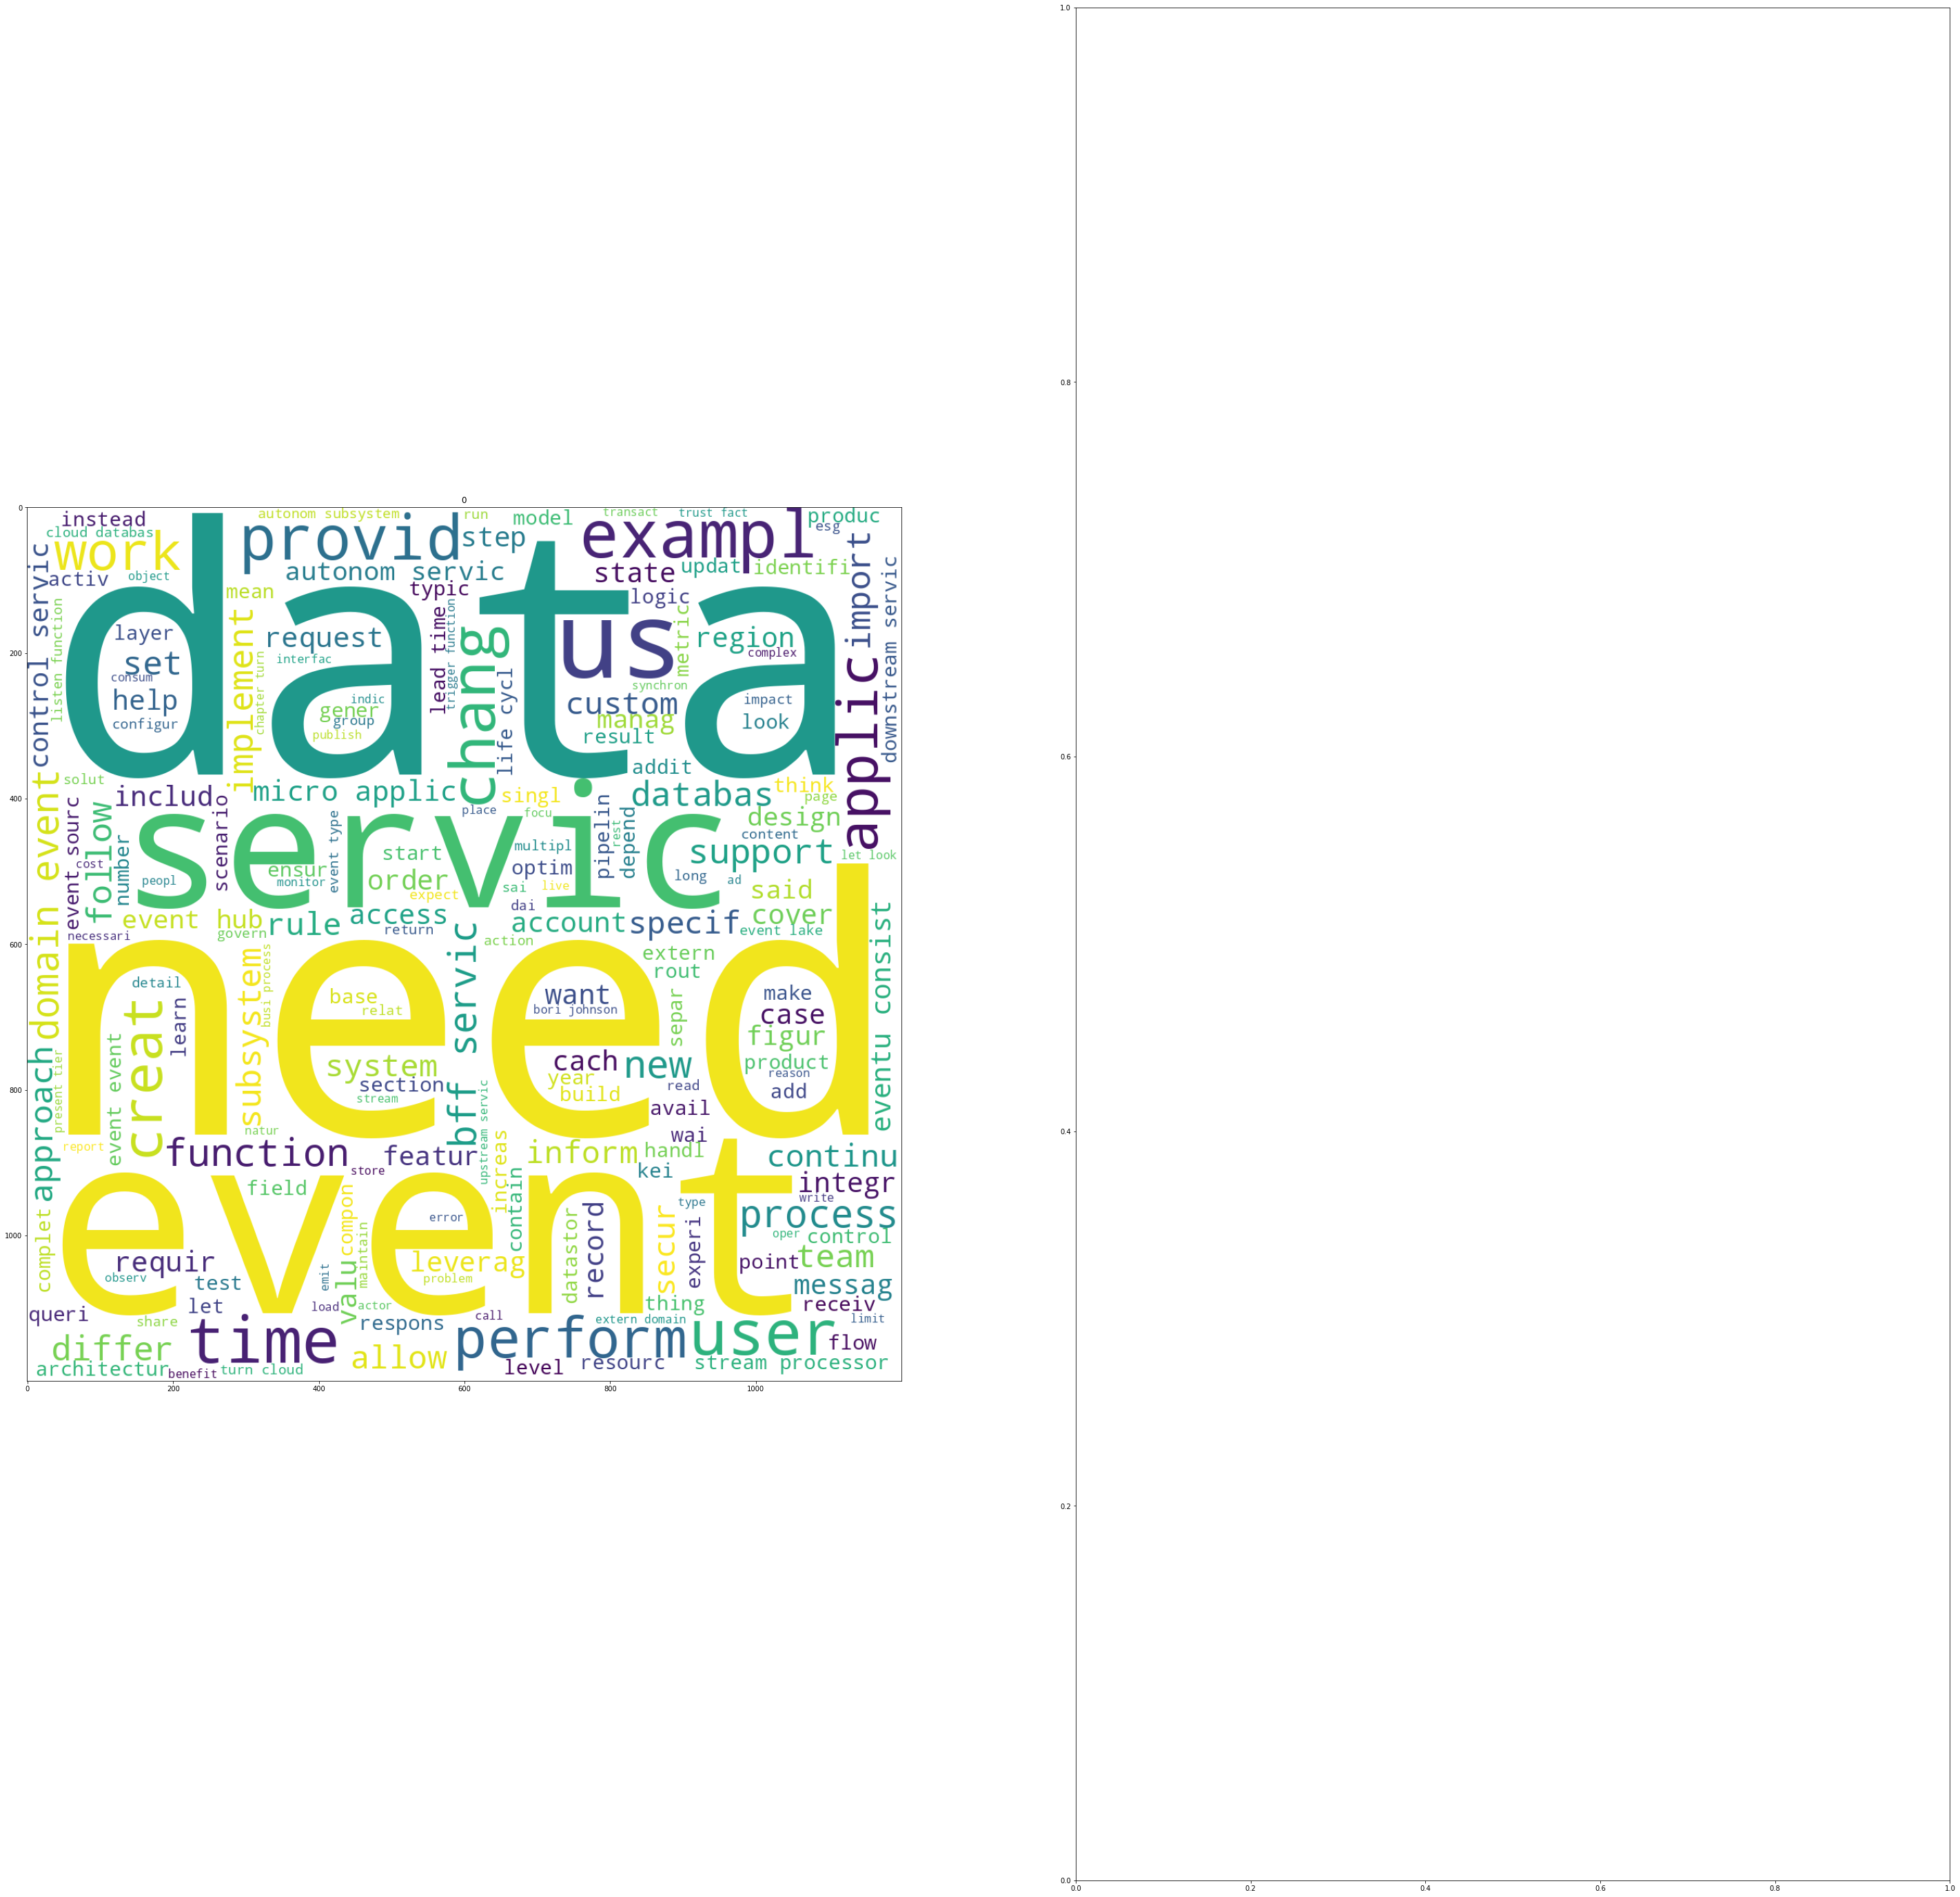

In [140]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize = (50,50))
wordcloud = WordCloud(background_color = 'white',
                              width = 1200,
                              height = 1200).generate(text_by_clusters[0][0]) 
ax[0].imshow(wordcloud)
ax[0].title.set_text(str(text_by_clusters[0][1]))


#fig, ax = plt.subplots(1,19, figsize = (25,19))

#for i in range(len(text_by_clusters)):
#    wordcloud = WordCloud(background_color = 'white',
#                              width = 1200,
#                              height = 1200).generate(text_by_clusters[i][0]) 
#    ax[i].imshow(wordcloud)
#    ax[i].grid(False)
#    ax[i].axis('off')
#    ax[i].title.set_text(str(text_by_clusters[i][1]))